<a href="https://colab.research.google.com/github/Antonela89/Robot_Trading_Optimizado/blob/main/Robot_Trading_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1- Pereparación de ambientes

In [1]:
import yfinance as yf
import pandas as pd
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

2 - Obtención de datos

In [2]:
def importar_base_bitcoin():
    try:
        bitcoin = yf.Ticker('BTC-USD')
        df_bitcoin = bitcoin.history(period='7d', interval='5m')
        return df_bitcoin
    except Exception as e:
        print(f"Error al importar datos de Bitcoin: {str(e)}")
        return None

def extraer_tendencias():
    try:
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:109.0) Gecko/20100101 Firefox/118.0'}
        url = 'https://coinmarketcap.com'
        respuesta = requests.get(url, headers=headers)
        respuesta.raise_for_status()  # Lanzar una excepción si hay un error HTTP
        s = BeautifulSoup(respuesta.content, features='lxml')
        precio = s.find('a', {'href': '/currencies/bitcoin/#markets'})
        precio_actual = precio.text.replace(',', '').replace('$', '')
        precio_actual = float(precio_actual)
        tendencia = s.find('span',{'class':'sc-d55c02b-0'})
        tendencia_color = tendencia['class'][1]
        tendencia_icono = tendencia.span['class']

        if (tendencia_color == 'gUnzUB' and  tendencia_icono == ['icon-Caret-down']):
          tendencia = 'baja'
        elif (tendencia_color == 'iwhBxy' and tendencia_icono == ['icon-Caret-up']):
          tendencia = 'alta'

        return precio_actual, tendencia
    except requests.exceptions.RequestException as e:
        print(f"Error en la solicitud web: {str(e)}")
        return None
    except Exception as e:
        print(f"Error inesperado: {str(e)}")
        return None


3 - Limpieza de datos

In [3]:
def limpieza_datos(df_bitcoin_limpio):
    df_bitcoin_limpio.drop_duplicates(inplace=True)
    df_bitcoin_limpio = df_bitcoin_limpio.dropna(subset=['Close'])
    df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio['Volume'] != 0]
    precio_cierre = df_bitcoin_limpio['Close']
    Q1 = precio_cierre.quantile(0.25)
    Q3 = precio_cierre.quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    seleccion = ((precio_cierre >= Q1) & (precio_cierre <= Q3))
    df_nuevo = df_bitcoin_limpio[seleccion]
    media_bitcoin = df_nuevo['Close'].mean()
    return media_bitcoin

4 - Toma de Decisiones

In [4]:
def tomar_decisiones(precio_actual, media_bitcoin, tendencia):
    if precio_actual <= media_bitcoin and tendencia == 'alta':
        algoritmo_decision = 'Comprar'
    elif precio_actual >= media_bitcoin and tendencia == 'baja':
        algoritmo_decision = 'Vender'
    else:
        algoritmo_decision = 'Esperar'
    return algoritmo_decision

5 - Visualización

In [5]:
def visualizacion(df_bitcoin, media_bitcoin, algoritmo_decision):
    df_bitcoin['Promedio'] = media_bitcoin
    plt.rc('figure', figsize=(16, 5))
    plt.subplot()
    plt.title('Variación de precio de cierre de Bitcoin durante 7 días');
    plt.xlabel('Fechas')
    plt.ylabel('Precios')
    plt.plot(df_bitcoin.index,df_bitcoin.Close, label = 'Precio cierre Bitcoin');
    plt.plot(df_bitcoin.index,df_bitcoin.Promedio, label = 'Promedio');
    plt.annotate(f'Decisión: {algoritmo_decision}',xy=(df_bitcoin.index[0], df_bitcoin.Close[0]), xytext=(df_bitcoin.index[0], df_bitcoin.Close[-1]))
    plt.legend(loc='upper right', bbox_to_anchor=(0, 0.08, 0.2, 0.9))
    plt.show()

6 - Automatización

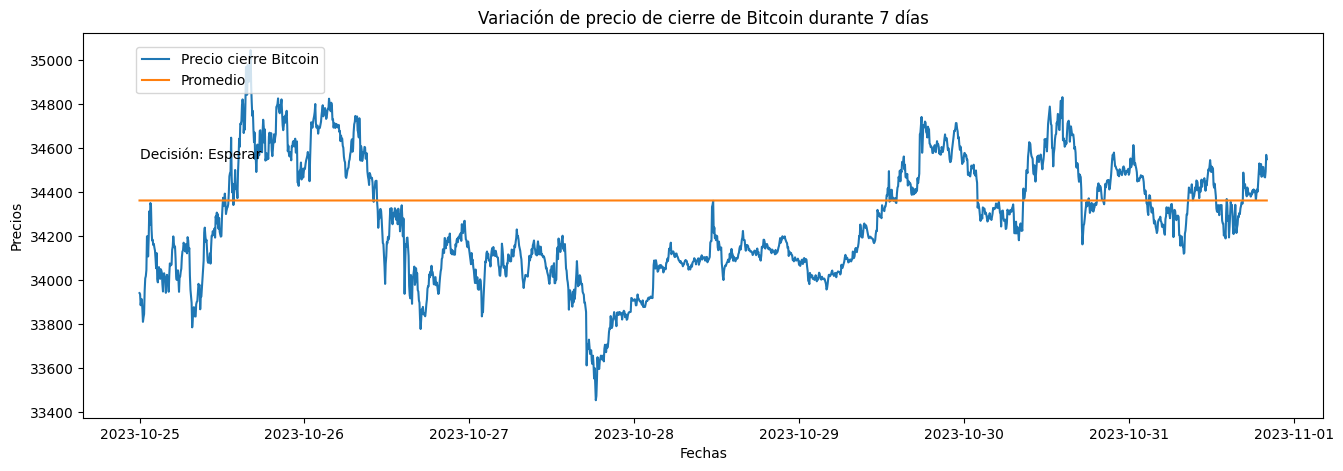

In [ ]:
while True:
    clear_output()
    df_bitcoin = importar_base_bitcoin()
    if df_bitcoin is not None:
        precio_actual, tendencia = extraer_tendencias()
        if precio_actual is not None and tendencia is not None:
            df_bitcoin_limpio = df_bitcoin.copy()
            media_bitcoin = limpieza_datos(df_bitcoin_limpio)
            algoritmo_decision = tomar_decisiones(precio_actual, media_bitcoin, tendencia)
            visualizacion(df_bitcoin, media_bitcoin, algoritmo_decision)
    time.sleep(300)